In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# !unzip /content/drive/My\ Drive/gan19_red2white_roses.zip

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm, tqdm_notebook
import glob
import random
import itertools
import torchvision.utils as vutils
from torchsummary import summary

%matplotlib inline

In [5]:
SEED = 21

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
batch_size = 6
image_size =(128, 128)
save_weights_path = "/content/drive/My Drive/weights_gan19"

In [8]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode="train"):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, f"{mode}A") + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, f"{mode}B") + "/*.*"))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [9]:
dataset = ImageDataset(root=os.path.join("/content/", "gan19_red2white_roses"),
                       transform=transforms.Compose([
                           transforms.Resize(image_size, Image.BICUBIC),
                           transforms.RandomHorizontalFlip(),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]), mode='test'
                       )
inv_normalize = transforms.Normalize(
    mean=[-1., -1., -1.],
    std=[2., 2., 2.]
)


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [10]:
unloader = transforms.ToPILImage()

def imshow(tensor, title):
    plt.figure()
    
    image = inv_normalize(tensor.cpu().clone())  
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)

In [11]:
len(dataloader)*batch_size

108

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.last = nn.Conv2d(128, 1, 4, padding=1)

      

    def forward(self, x):
        x = self.main(x)
        x = self.last(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )
        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.output(self.upsampling(self.main(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels=256):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

In [14]:
netG_A2B = Generator().to(device)
netG_B2A = Generator().to(device)
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

In [15]:
# summary(netG_A2B, (3,*image_size))

In [16]:
# summary(netD_A, (3,*image_size))

In [19]:
# # if train broke off need to initialisate NN with weights

name_dataset = 'red2white_roses'
netG_A2B.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netG_A2B.pth",map_location=torch.device(device)))
netG_B2A.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netG_B2A.pth",map_location=torch.device(device)))
netD_A.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netD_A.pth",map_location=torch.device(device)))
netD_B.load_state_dict(torch.load(f"{save_weights_path}/{name_dataset}/netD_B.pth",map_location=torch.device(device)))

<All keys matched successfully>

In [20]:
# losses
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)
adversarial_loss = torch.nn.MSELoss().to(device)

In [21]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [22]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert (max_size > 0), "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)



  0%|          | 0/18 [00:00<?, ?it/s]

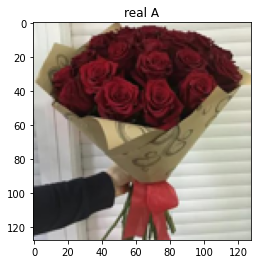

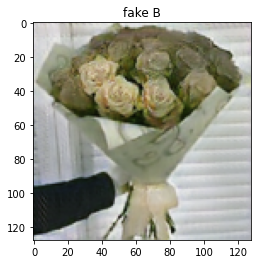

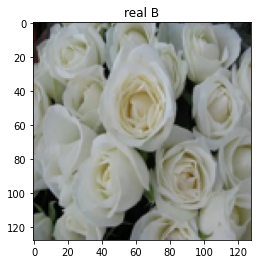

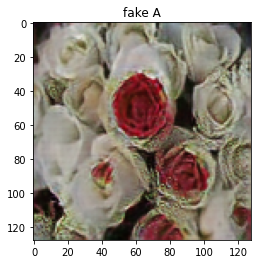


  6%|▌         | 1/18 [00:34<09:54, 34.99s/it]

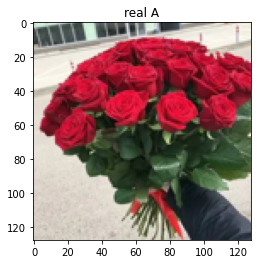

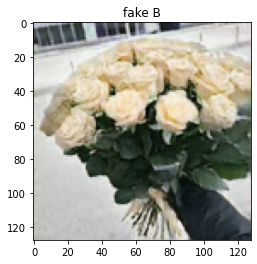

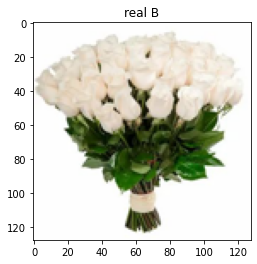

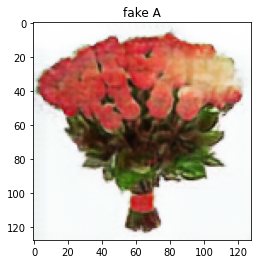


 11%|█         | 2/18 [01:10<09:20, 35.00s/it]

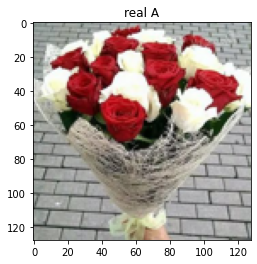

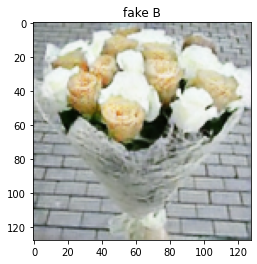

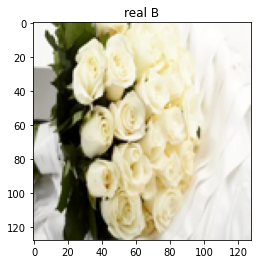

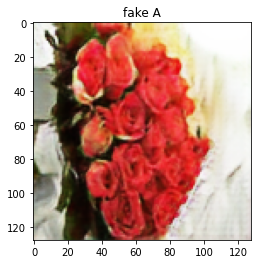


 17%|█▋        | 3/18 [01:45<08:44, 35.00s/it]

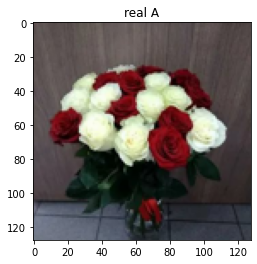

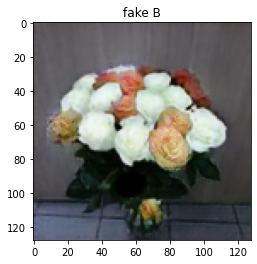

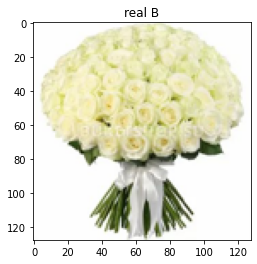

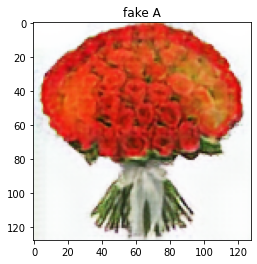


 22%|██▏       | 4/18 [02:19<08:09, 34.97s/it]

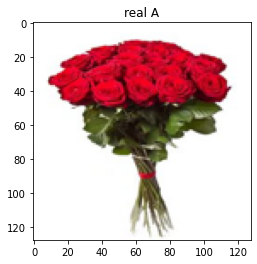

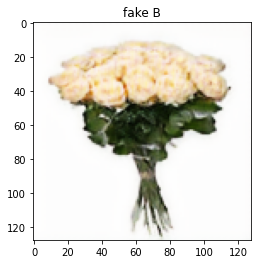

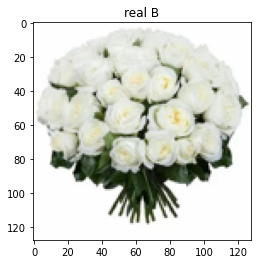

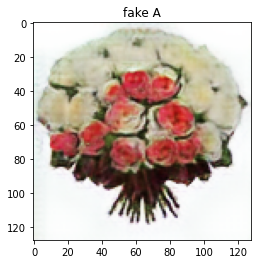


 28%|██▊       | 5/18 [02:54<07:34, 34.95s/it]

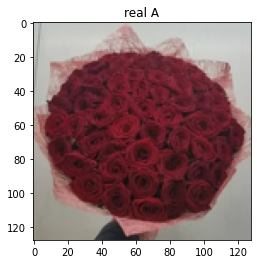

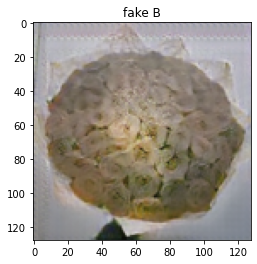

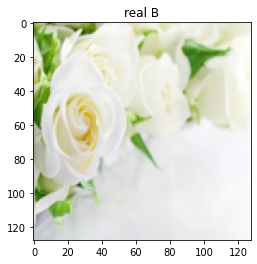

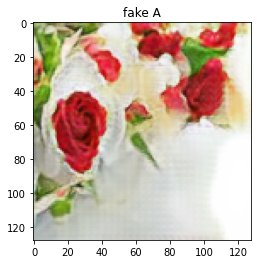


 33%|███▎      | 6/18 [03:29<06:59, 34.96s/it]

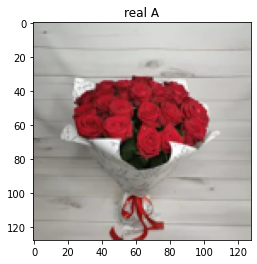

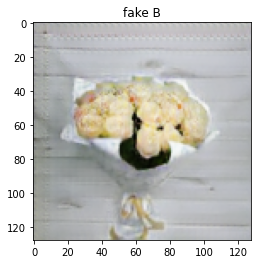

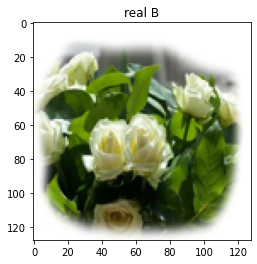

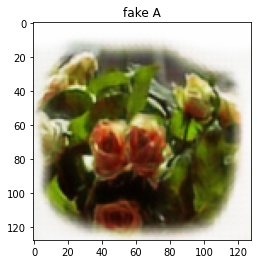


 39%|███▉      | 7/18 [04:04<06:24, 34.95s/it]

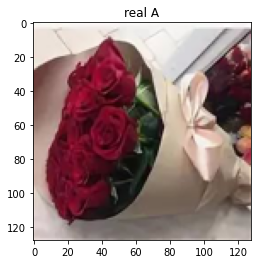

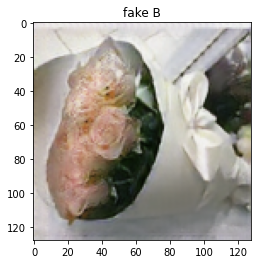

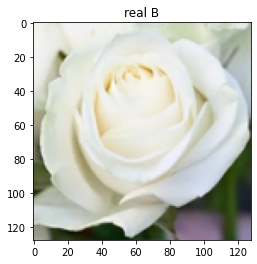

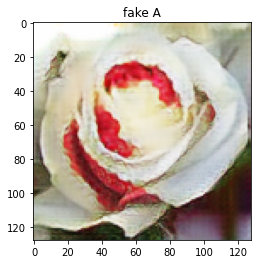


 44%|████▍     | 8/18 [04:39<05:49, 34.92s/it]

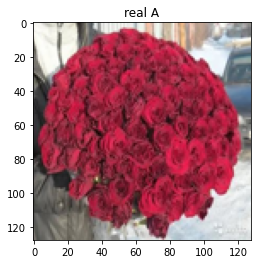

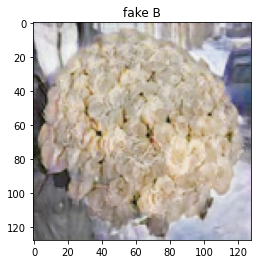

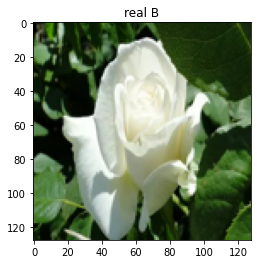

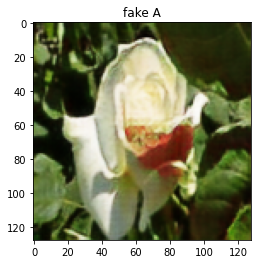


 50%|█████     | 9/18 [05:14<05:14, 34.96s/it]

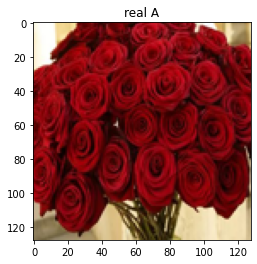

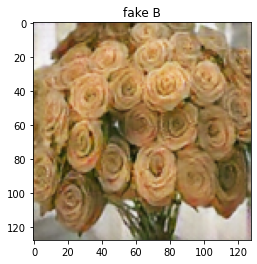

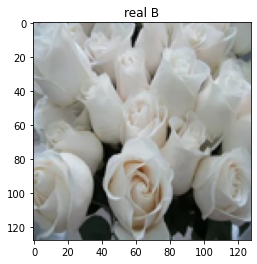

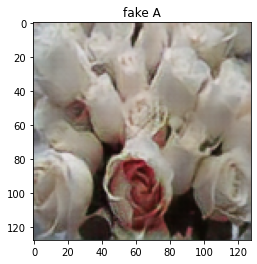


 56%|█████▌    | 10/18 [05:53<04:48, 36.08s/it]

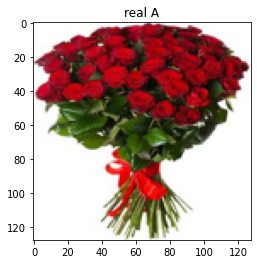

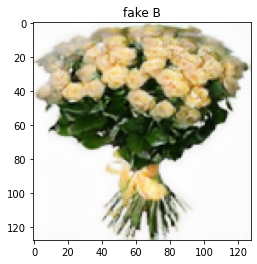

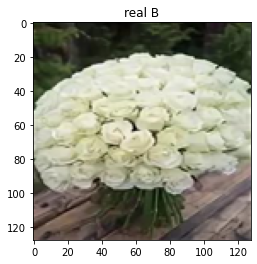

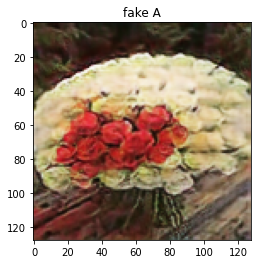


 61%|██████    | 11/18 [06:28<04:10, 35.74s/it]

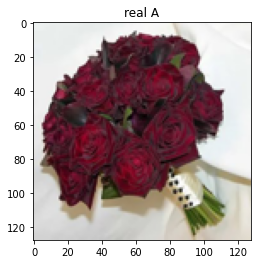

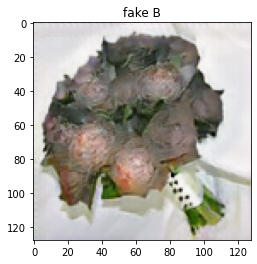

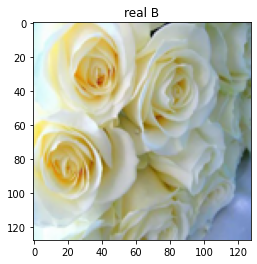

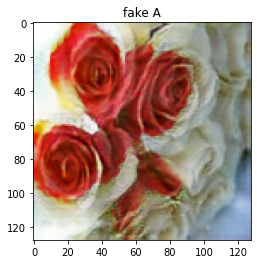


 67%|██████▋   | 12/18 [07:03<03:33, 35.51s/it]

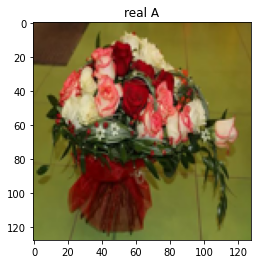

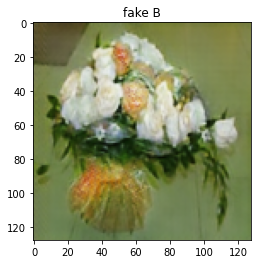

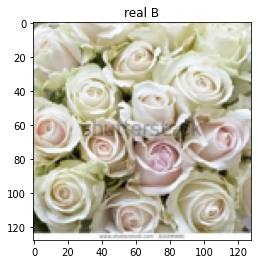

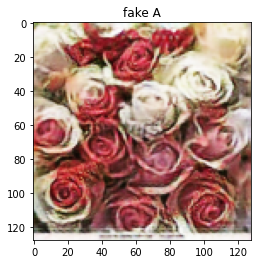


 72%|███████▏  | 13/18 [07:38<02:56, 35.40s/it]

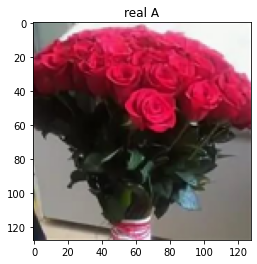

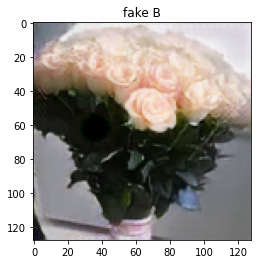

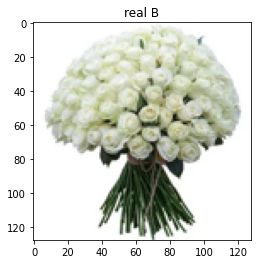

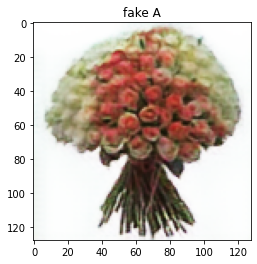


 78%|███████▊  | 14/18 [08:13<02:21, 35.31s/it]

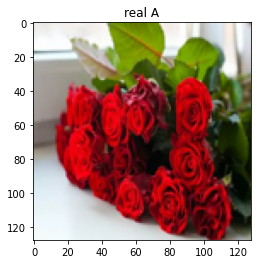

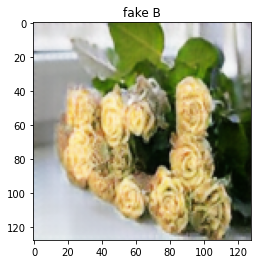

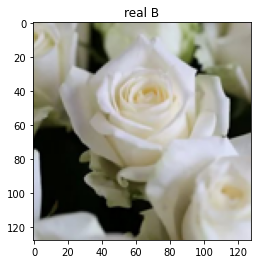

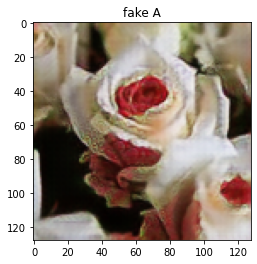


 83%|████████▎ | 15/18 [08:48<01:45, 35.21s/it]

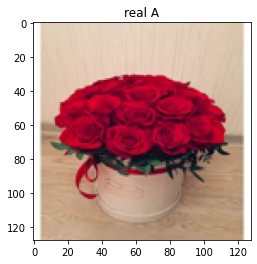

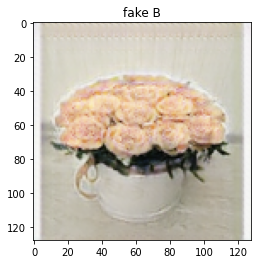

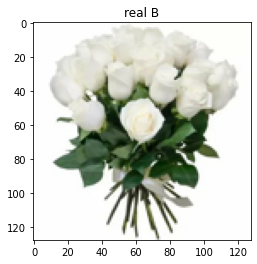

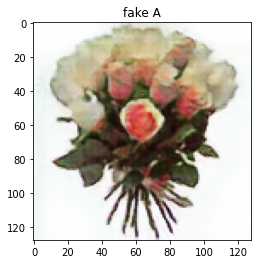


 89%|████████▉ | 16/18 [09:23<01:10, 35.14s/it]

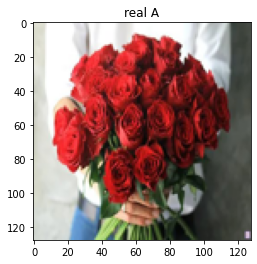

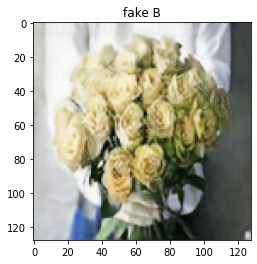

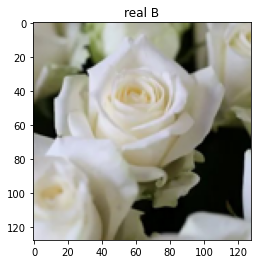

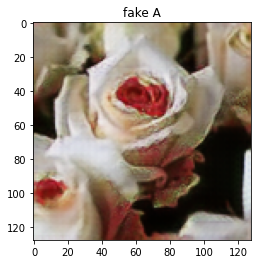


 94%|█████████▍| 17/18 [09:58<00:35, 35.09s/it]

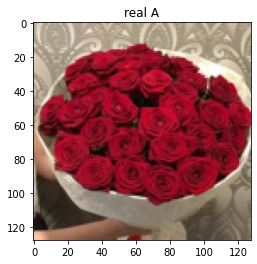

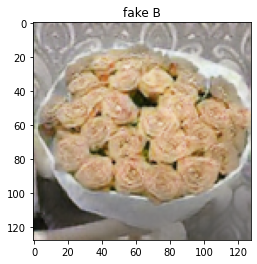

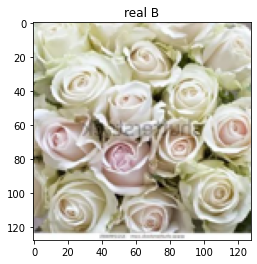

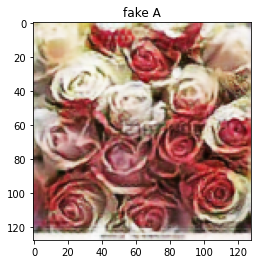


100%|██████████| 18/18 [10:22<00:00, 34.56s/it]


In [28]:
identity_losses = []
gan_losses = []
cycle_losses = []

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()


progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))

netG_A2B.eval() 
netG_B2A.eval()
netD_A.eval() 
netD_B.eval() 

with torch.no_grad():
  for i, data in progress_bar:
      # get batch size data
      real_image_A = data["A"].to(device)
      real_image_B = data["B"].to(device)
      batch_size = real_image_A.size(0)

      # real data label is 1, fake data label is 0.
      real_label = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32)
      fake_label = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32)

      ##############################################
      # (1) calculate G network losses: Generators A2B and B2A
      ##############################################

      # Identity loss
      # G_B2A(A) should equal A if real A is fed
      identity_image_A = netG_B2A(real_image_A)
      loss_identity_A = identity_loss(identity_image_A, real_image_A) * 5.0
      # G_A2B(B) should equal B if real B is fed
      identity_image_B = netG_A2B(real_image_B)
      loss_identity_B = identity_loss(identity_image_B, real_image_B) * 5.0

      # GAN loss
      # GAN loss D_A(G_A(A))
      fake_image_A = netG_B2A(real_image_B)
      fake_output_A = netD_A(fake_image_A)
      loss_GAN_B2A = adversarial_loss(fake_output_A, real_label)
      # GAN loss D_B(G_B(B))
      fake_image_B = netG_A2B(real_image_A)
      fake_output_B = netD_B(fake_image_B)
      loss_GAN_A2B = adversarial_loss(fake_output_B, real_label)

      # Cycle loss
      recovered_image_A = netG_B2A(fake_image_B)
      loss_cycle_ABA = cycle_loss(recovered_image_A, real_image_A) * 10.0

      recovered_image_B = netG_A2B(fake_image_A)
      loss_cycle_BAB = cycle_loss(recovered_image_B, real_image_B) * 10.0


      ##############################################
      # (2) calculate D network loss: Discriminator A
      ##############################################

      # Real A image loss
      real_output_A = netD_A(real_image_A)
      errD_real_A = adversarial_loss(real_output_A, real_label)

      # Fake A image loss
      fake_image_A = fake_A_buffer.push_and_pop(fake_image_A)
      fake_output_A = netD_A(fake_image_A.detach())
      errD_fake_A = adversarial_loss(fake_output_A, fake_label)

      ##############################################
      # (3) calculate D network loss: Discriminator B
      ##############################################

      # Real B image loss
      real_output_B = netD_B(real_image_B)
      errD_real_B = adversarial_loss(real_output_B, real_label)

      # Fake B image loss
      fake_image_B = fake_B_buffer.push_and_pop(fake_image_B)
      fake_output_B = netD_B(fake_image_B.detach())
      errD_fake_B = adversarial_loss(fake_output_B, fake_label)

            
      identity_losses.append((loss_identity_A + loss_identity_B).item())
      gan_losses.append((loss_GAN_A2B + loss_GAN_B2A).item())
      cycle_losses.append((loss_cycle_ABA + loss_cycle_BAB).item())
      
      fake_image_A = netG_B2A(real_image_B).data
      fake_image_B = netG_A2B(real_image_A).data

      n = 1
      imshow(real_image_A[n],"real A")
      imshow(fake_image_B.detach()[n],"fake B")

      imshow(real_image_B[n],"real B")
      imshow(fake_image_A.detach()[n],"fake A")
      
      plt.show()

на самом деле по выводам картинок видно, что из красного в белый переводит просто отлично, а вот из белого в красный не очень отлично. я предполагаю, это связано с тем, что я полностью очистил датасет с красными розами от белых, а вот в белых есть некоторые смешанные букеты - как раз с красными и белыми розами(хотя их было немного, поэтому не стал чистить). это и объясняет, почему часто красится только часть букета. к сожалению, я потратил все свое время на другую задачу, в которой надо было менять текстуры картинок, а не только стили, однако лишь в конце дедлайна узнал о том, что стандартный cycle gan не умеет менять текстуры. там нужно было применять несколько другую архитектуру, которая учится дольше и которую я пока не сделал. однако, как видно выше, стандартный cycle gan отлично справляется с переносом стиля. была интересная домашка, попробовал какое-то огромное количество попыток на разных задачах, однако надо было просто выбрать другую задачу или имплементировать другую статью. зато я попробовал много экспериментов и многие оказались удачные, хотя неудачных во много раз больше😂

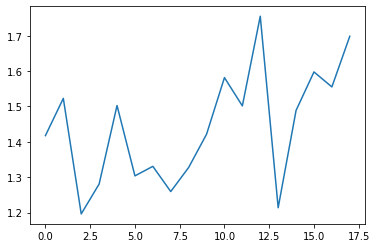

In [29]:
plt.plot(identity_losses);

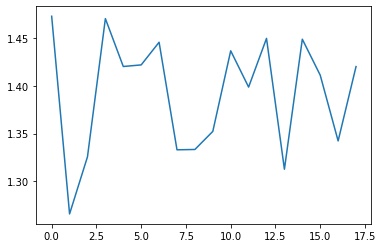

In [30]:
plt.plot(cycle_losses);

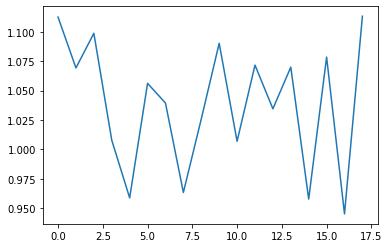

In [31]:
plt.plot(gan_losses);